Loaded NDVI and TCI for: C:\Users\gagan\OneDrive\Desktop\GMU\DAEN_690\Sentinel_2_Data\S2A_17TLJ_20190505_0_L2A
Loaded NDVI and TCI for: C:\Users\gagan\OneDrive\Desktop\GMU\DAEN_690\Sentinel_2_Data\S2A_17TLJ_20190714_0_L2A
Loaded NDVI and TCI for: C:\Users\gagan\OneDrive\Desktop\GMU\DAEN_690\Sentinel_2_Data\S2A_17TLJ_20190724_0_L2A
Loaded NDVI and TCI for: C:\Users\gagan\OneDrive\Desktop\GMU\DAEN_690\Sentinel_2_Data\S2B_17TLJ_20190801_1_L2A
Loaded NDVI and TCI for: C:\Users\gagan\OneDrive\Desktop\GMU\DAEN_690\Sentinel_2_Data\S2B_17TLJ_20190907_0_L2A
Each NDVI image shape: (336, 451)
Stacked NDVI shape: (5, 336, 451)
Stacked TCI shape: (15, 336, 451)
Stacked NDVI saved at: C:\Users\gagan\OneDrive\Desktop\GMU\DAEN_690\Sentinel_2_Data\Stacked_Files_SVM\NDVI_Stack_SVM.tif
Stacked TCI saved at: C:\Users\gagan\OneDrive\Desktop\GMU\DAEN_690\Sentinel_2_Data\Stacked_Files_SVM\TCI_Stack_SVM.tif


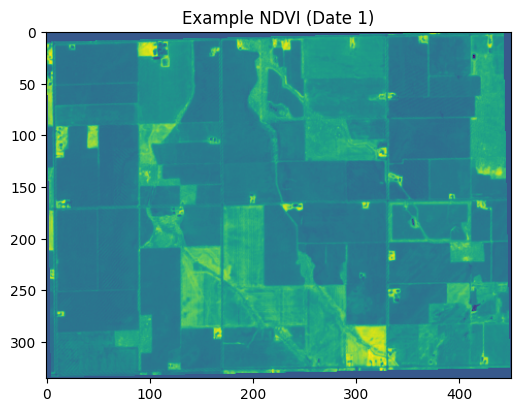

In [ ]:
import os
import numpy as np
import rasterio
import matplotlib.pyplot as plt

# List your date folders in the desired order.
date_folders = [
    r"C:\Users\gagan\OneDrive\Desktop\GMU\DAEN_690\Sentinel_2_Data\S2A_17TLJ_20190505_0_L2A",
    r"C:\Users\gagan\OneDrive\Desktop\GMU\DAEN_690\Sentinel_2_Data\S2A_17TLJ_20190714_0_L2A",
    r"C:\Users\gagan\OneDrive\Desktop\GMU\DAEN_690\Sentinel_2_Data\S2A_17TLJ_20190724_0_L2A",
    r"C:\Users\gagan\OneDrive\Desktop\GMU\DAEN_690\Sentinel_2_Data\S2B_17TLJ_20190801_1_L2A",
    r"C:\Users\gagan\OneDrive\Desktop\GMU\DAEN_690\Sentinel_2_Data\S2B_17TLJ_20190907_0_L2A"
]

# We'll assume that in each date folder you already have a subfolder named "Clipped_AOI"
# that contains:
#   NDVI_AOI.tif  (single band NDVI image)
#   TCI_AOI.tif   (3-band true color image)

ndvi_stack_list = []  # To accumulate the NDVI arrays from each date.
tci_stack_list = []   # To accumulate the TCI arrays (each with 3 bands) from each date.
ref_transform = None  # Reference transform from the first file.
ref_crs = None        # Reference CRS from the first file.

for folder in date_folders:
    clip_folder = os.path.join(folder, "Clipped_AOI")
    
    # Path for NDVI and TCI for this date.
    ndvi_fp = os.path.join(clip_folder, "NDVI_AOI.tif")
    tci_fp  = os.path.join(clip_folder, "TCI_AOI.tif")
    
    # Load NDVI (expected shape: [rows, cols])
    with rasterio.open(ndvi_fp) as src:
        ndvi_img = src.read(1)  
        if ref_transform is None:
            ref_transform = src.transform
            ref_crs = src.crs
    ndvi_stack_list.append(ndvi_img)
    
    # Load TCI (expected shape: [3, rows, cols])
    with rasterio.open(tci_fp) as src:
        tci_img = src.read()
    tci_stack_list.append(tci_img)
    print(f"Loaded NDVI and TCI for: {folder}")

# Check that each NDVI image has the same dimensions.
n_dates = len(ndvi_stack_list)
rows, cols = ndvi_stack_list[0].shape
print(f"Each NDVI image shape: ({rows}, {cols})")

# Stack NDVI images along a new first dimension → shape: (n_dates, rows, cols)
stacked_ndvi = np.stack(ndvi_stack_list, axis=0)

# For TCI, each image is 3 bands. We'll concatenate them along the first dimension → shape: (n_dates*3, rows, cols)
stacked_tci = np.concatenate(tci_stack_list, axis=0)

print("Stacked NDVI shape:", stacked_ndvi.shape)
print("Stacked TCI shape:", stacked_tci.shape)

# -------------------------------------------------------------------
# Save the Stacked NDVI and TCI into a New Output Folder Called "Stacked_Files_SVM"
# -------------------------------------------------------------------
output_folder = r"C:\Users\gagan\OneDrive\Desktop\GMU\DAEN_690\Sentinel_2_Data\Stacked_Files_SVM"
os.makedirs(output_folder, exist_ok=True)

# Save the NDVI stack as a GeoTIFF:
ndvi_stack_path = os.path.join(output_folder, "NDVI_Stack_SVM.tif")
with rasterio.open(os.path.join(date_folders[0], "Clipped_AOI", "NDVI_AOI.tif")) as src:
    ndvi_meta = src.meta.copy()
ndvi_meta.update({
    "count": stacked_ndvi.shape[0],
    "dtype": stacked_ndvi.dtype,
    "height": stacked_ndvi.shape[1],
    "width": stacked_ndvi.shape[2],
    "transform": ref_transform,
    "crs": ref_crs
})
with rasterio.open(ndvi_stack_path, "w", **ndvi_meta) as dst:
    for i in range(stacked_ndvi.shape[0]):
        dst.write(stacked_ndvi[i, :, :], i+1)
print("Stacked NDVI saved at:", ndvi_stack_path)

# Save the TCI stack as a GeoTIFF:
tci_stack_path = os.path.join(output_folder, "TCI_Stack_SVM.tif")
with rasterio.open(os.path.join(date_folders[0], "Clipped_AOI", "TCI_AOI.tif")) as src:
    tci_meta = src.meta.copy()
tci_meta.update({
    "count": stacked_tci.shape[0],
    "dtype": stacked_tci.dtype,
    "height": stacked_tci.shape[1],
    "width": stacked_tci.shape[2],
    "transform": ref_transform,
    "crs": ref_crs
})
with rasterio.open(tci_stack_path, "w", **tci_meta) as dst:
    for i in range(stacked_tci.shape[0]):
        dst.write(stacked_tci[i, :, :], i+1)
print("Stacked TCI saved at:", tci_stack_path)

# (Optional) Visualize one example date from the NDVI stack.
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(stacked_ndvi[0], cmap="viridis")
ax.set_title("Example NDVI (Date 1)")
plt.show()


In [1]:
# List your date folders in the desired order.
date_folders = [
    r"C:\Users\gagan\OneDrive\Desktop\GMU\DAEN_690\Sentinel_2_Data\S2A_17TLJ_20190505_0_L2A",
    r"C:\Users\gagan\OneDrive\Desktop\GMU\DAEN_690\Sentinel_2_Data\S2A_17TLJ_20190714_0_L2A",
    r"C:\Users\gagan\OneDrive\Desktop\GMU\DAEN_690\Sentinel_2_Data\S2A_17TLJ_20190724_0_L2A",
    r"C:\Users\gagan\OneDrive\Desktop\GMU\DAEN_690\Sentinel_2_Data\S2B_17TLJ_20190801_1_L2A",
    r"C:\Users\gagan\OneDrive\Desktop\GMU\DAEN_690\Sentinel_2_Data\S2B_17TLJ_20190907_0_L2A"
]

In [2]:
import os
import numpy as np
import rasterio

# Define file paths for the stacked files used for SVM.
ndvi_stack_path = r"C:\Users\gagan\OneDrive\Desktop\GMU\DAEN_690\Sentinel_2_Data\Stacked_Files_SVM\NDVI_Stack_SVM.tif"
tci_stack_path  = r"C:\Users\gagan\OneDrive\Desktop\GMU\DAEN_690\Sentinel_2_Data\Stacked_Files_SVM\TCI_Stack_SVM.tif"

# Read the NDVI stack (expected shape: (5, rows, cols))
with rasterio.open(ndvi_stack_path) as src:
    stacked_ndvi = src.read()  # shape: (5, rows, cols)
    # We'll extract the rows and cols for later
    rows, cols = stacked_ndvi.shape[1], stacked_ndvi.shape[2]

# Read the TCI stack (expected shape: (15, rows, cols))
with rasterio.open(tci_stack_path) as src:
    stacked_tci = src.read()  # shape: (15, rows, cols)

# Reshape so that each pixel is a row.
# For NDVI: from (5, rows, cols) to (rows*cols, 5)
X_ndvi = stacked_ndvi.reshape(5, -1).T

# For TCI: from (15, rows, cols) to (rows*cols, 15)
X_tci = stacked_tci.reshape(15, -1).T

# Concatenate the two feature sets to obtain 20 features per pixel.
X_multi = np.hstack([X_ndvi, X_tci])
print("Multi-temporal feature matrix shape:", X_multi.shape)
# Expected shape is (rows*cols, 20)


Multi-temporal feature matrix shape: (151536, 20)


In [3]:
# Ground truth mask path (adjust this path if different)
gt_mask_path = r"C:\Users\gagan\OneDrive\Desktop\GMU\DAEN_690\Sentinel_2_Data\chandana_ground_truth_mask.tif"

with rasterio.open(gt_mask_path) as src:
    gt_mask = src.read(1)  # shape: (rows, cols)

# Flatten the ground truth mask.
y_all = gt_mask.flatten()

# Create a valid index mask (exclude nodata values, assumed to be 255).
valid_idx = (y_all != 255)

# Filter the ground truth labels to use only valid data.
X_valid = X_multi[valid_idx]
y_valid = y_all[valid_idx]

print("Valid features shape:", X_valid.shape)
print("Valid labels shape:", y_valid.shape)

# Optionally, check label distribution.
unique, counts = np.unique(y_valid, return_counts=True)
print("Label distribution:", dict(zip(unique, counts)))


Valid features shape: (151536, 20)
Valid labels shape: (151536,)
Label distribution: {0: 37800, 1: 113736}


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Scale the features.
scaler = StandardScaler()
X_valid_scaled = scaler.fit_transform(X_valid)

# Split data into training and validation sets (80/20 split).
X_train, X_val, y_train, y_val = train_test_split(
    X_valid_scaled, y_valid, test_size=0.2, random_state=42, stratify=y_valid
)

print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)


Training set shape: (121228, 20)
Validation set shape: (30308, 20)


In [5]:
import time
from joblib import load, dump
from sklearn.svm import SVC

# Initialize the SVM. Adjust parameters (C, gamma) as needed.
svm_clf = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=42)

start_time = time.time()
svm_clf.fit(X_train, y_train)
training_time = time.time() - start_time
print("SVM Training Time: {:.4f} seconds".format(training_time))

# Save model and scaler
dump(svm_clf, "svm_clf.pkl")
dump(scaler, "svm_scaler.pkl")
print("SVM model and scaler saved to disk.")


SVM Training Time: 334.6038 seconds
SVM model and scaler saved to disk.


In [6]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

start_time = time.time()
y_pred_val = svm_clf.predict(X_val)
prediction_time = time.time() - start_time

acc = accuracy_score(y_val, y_pred_val)
print("SVM Validation Accuracy: {:.4f}".format(acc))
print("Prediction Time on Validation:", prediction_time, "seconds")

print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred_val))
print("Classification Report:")
print(classification_report(y_val, y_pred_val, target_names=["Non-field", "Field"]))


SVM Validation Accuracy: 0.9526
Prediction Time on Validation: 23.54559063911438 seconds
Confusion Matrix:
[[ 6722   838]
 [  600 22148]]
Classification Report:
              precision    recall  f1-score   support

   Non-field       0.92      0.89      0.90      7560
       Field       0.96      0.97      0.97     22748

    accuracy                           0.95     30308
   macro avg       0.94      0.93      0.94     30308
weighted avg       0.95      0.95      0.95     30308



SVM Prediction map shape: (336, 451)


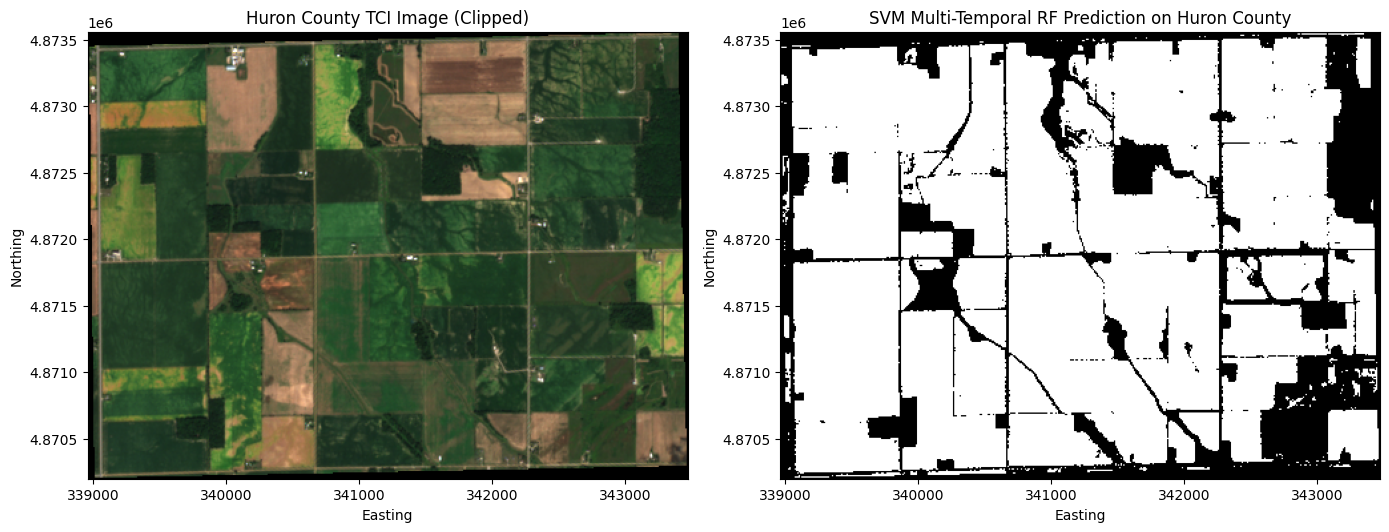

In [7]:
# Predict on the full scaled multi-temporal feature matrix for valid pixels.
y_pred_full = svm_clf.predict(X_valid_scaled)

# Create an array that will hold predictions for all pixels.
pred_full = np.full(y_all.shape, fill_value=255, dtype=y_all.dtype)
pred_full[valid_idx] = y_pred_full

# Reshape predictions back to image dimensions.
pred_map_svm = pred_full.reshape(rows, cols)
print("SVM Prediction map shape:", pred_map_svm.shape)

# For visualization, we'll use one of the clipped TCI images for georeferencing.
# For example, use the TCI_AOI.tif file from the first date.
with rasterio.open(os.path.join(date_folders[4], "Clipped_AOI", "TCI_AOI.tif")) as src:
    tci_vis = src.read().transpose((1, 2, 0))
    bounds = src.bounds

import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
axes[0].imshow(tci_vis, extent=(bounds.left, bounds.right, bounds.bottom, bounds.top))
axes[0].set_title("Huron County TCI Image (Clipped)")
axes[0].set_xlabel("Easting")
axes[0].set_ylabel("Northing")
axes[1].imshow(pred_map_svm, cmap="gray", extent=(bounds.left, bounds.right, bounds.bottom, bounds.top))
axes[1].set_title("SVM Multi-Temporal RF Prediction on Huron County")
axes[1].set_xlabel("Easting")
axes[1].set_ylabel("Northing")
plt.tight_layout()
plt.show()


In [8]:
import numpy as np
import rasterio
import os

# -------------------------------
# Step 1: Calculate IoU for the Field Class (label 1)
# -------------------------------

# Load the ground truth mask.
gt_mask_path = r"C:\Users\gagan\OneDrive\Desktop\GMU\DAEN_690\Sentinel_2_Data\chandana_ground_truth_mask.tif"
with rasterio.open(gt_mask_path) as src:
    gt_mask = src.read(1)  # Expected shape: (rows, cols)

# Create a valid mask to exclude nodata values (assumed nodata is 255).
valid_idx = (gt_mask != 255)

# Select only valid pixels from the ground truth and the SVM prediction.
gt_valid = gt_mask[valid_idx]
pred_valid = pred_map_svm[valid_idx]

# Compute intersection and union for pixels labeled as "field" (value == 1).
intersection = np.sum((gt_valid == 1) & (pred_valid == 1))
union = np.sum((gt_valid == 1) | (pred_valid == 1))
iou_field = intersection / union if union > 0 else 0
print("IoU for Field (class 1) with SVM:", iou_field)

# -------------------------------
# Step 2: Calculate Pixel Area for Acreage Computation
# -------------------------------
# We use one of the test clipped TCI images for georeferencing.
reference_tci = os.path.join(date_folders[0], "Clipped_AOI", "TCI_AOI.tif")
with rasterio.open(reference_tci) as src:
    transform = src.transform
    # Compute pixel area: |pixel width * pixel height|
    pixel_area = abs(transform.a * transform.e)
print("Pixel Area (m²):", pixel_area)

# -------------------------------
# Step 3: Calculate Total Predicted Field Acreage
# -------------------------------
# Count the number of pixels predicted as "field" (label == 1) in the SVM prediction.
field_pixel_count = np.sum(pred_map_svm == 1)
print("Number of Field Pixels:", field_pixel_count)

# Total area in square meters.
total_field_area_m2 = field_pixel_count * pixel_area

# Convert area from square meters to hectares (1 ha = 10,000 m²).
total_field_area_ha = total_field_area_m2 / 10000

# Convert area from hectares to acres (1 ha ≈ 2.47105 acres).
total_field_area_acres = total_field_area_ha * 2.47105

print("SVM Predicted Field Area:")
print(f"  {total_field_area_m2:.2f} m²")
print(f"  {total_field_area_ha:.2f} ha")
print(f"  {total_field_area_acres:.2f} acres")


IoU for Field (class 1) with SVM: 0.9388725648385617
Pixel Area (m²): 100.0
Number of Field Pixels: 114574
SVM Predicted Field Area:
  11457400.00 m²
  1145.74 ha
  2831.18 acres


In [ ]:
# === SVM Prediction on Full Huron County and Evaluation with new_cdl_polygons ===

import os
import numpy as np
import rasterio
from joblib import load, dump
from sklearn.preprocessing import StandardScaler
import geopandas as gpd
from rasterio.features import rasterize, shapes
from shapely.geometry import mapping, shape
import shapely.ops
from pyproj import Transformer
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.svm import SVC


# === Step 1: Load Full NDVI + TCI stacks ===
ndvi_stack_path = r"C:\Users\gagan\OneDrive\Desktop\GMU\DAEN_690\Sentinel_2_Data\Stacked_Files_SVM\NDVI_AOI_Stack.tif"
tci_stack_path  = r"C:\Users\gagan\OneDrive\Desktop\GMU\DAEN_690\Sentinel_2_Data\Stacked_Files_SVM\TCI_AOI_Stack.tif"

with rasterio.open(ndvi_stack_path) as src:
    ndvi_stack = src.read()
    ref_transform = src.transform
    ref_crs = src.crs
    rows, cols = ndvi_stack.shape[1], ndvi_stack.shape[2]

with rasterio.open(tci_stack_path) as src:
    tci_stack = src.read()

# === Step 2: Prepare feature matrix ===
X_ndvi = ndvi_stack.reshape(5, -1).T
X_tci  = tci_stack.reshape(15, -1).T
X_all  = np.hstack([X_ndvi, X_tci])

# === Step 3: Load trained SVM model and scaler ===
scaler = load("svm_scaler.pkl")
svm_clf = load("svm_clf.pkl")

X_scaled = scaler.transform(X_all)
y_pred = svm_clf.predict(X_scaled)
pred_map = y_pred.reshape(rows, cols)

In [6]:
# === Step 4: Save prediction GeoTIFF ===
pred_output_path = r"C:\Users\gagan\OneDrive\Desktop\GMU\DAEN_690\Sentinel_2_Data\Stacked_Files_SVM\Huron_County_SVM_RBF_Prediction.tif"
with rasterio.open(ndvi_stack_path) as src:
    meta = src.meta.copy()
    meta.update({"count": 1, "dtype": pred_map.dtype})
    with rasterio.open(pred_output_path, "w", **meta) as dst:
        dst.write(pred_map, 1)

In [ ]:
# === Step 5: Load and reproject new_cdl_polygons shapefile ===
shapefile_path = r"C:\Users\gagan\OneDrive\Desktop\GMU\DAEN_690\Sentinel_2_Data\NDVI\NDVI_Clipped_25_03\Binary_Segmentation_Outputs\Huron_County_Prediction\New_Cdl\new_cdl_polygons.shp"
polygons = gpd.read_file(shapefile_path)
transformer = Transformer.from_crs("EPSG:5070", ref_crs, always_xy=True)


projected_geometries = []
for feature in polygons.itertuples():
    geom = feature.geometry
    if geom.is_valid:
        geom_proj = shapely.ops.transform(transformer.transform, geom)
        projected_geometries.append(geom_proj)



In [ ]:
# # === Step 6: Create raster mask from projected polygons ===

polygon_mask = rasterize(
    [(geom, 1) for geom in projected_geometries],
    out_shape=(rows, cols),
    transform=ref_transform,
    fill=0,
    dtype=np.uint8,
    all_touched=True  # ensures better edge coverage
)


In [9]:
# === Step 7: Compute confusion metrics ===
y_true = polygon_mask.flatten()
y_pred = pred_map.flatten()

conf_matrix = confusion_matrix(y_true, y_pred)
class_report = classification_report(y_true, y_pred, target_names=["Background", "Field"], output_dict=True)

TP = conf_matrix[1][1]
FP = conf_matrix[0][1]
FN = conf_matrix[1][0]
TN = conf_matrix[0][0]

intersection = TP
union = TP + FP + FN
iou = intersection / union if union else 0
pixel_accuracy = TP / (TP + FN) if (TP + FN) else 0

PIXEL_AREA_M2 = 100
SQM_TO_ACRES = 1 / 4046.86

raster_total = (pred_map == 1).sum()
polygon_total = polygon_mask.sum()

pred_area_m2 = raster_total * PIXEL_AREA_M2
true_area_m2 = polygon_total * PIXEL_AREA_M2
pred_area_acres = pred_area_m2 * SQM_TO_ACRES
true_area_acres = true_area_m2 * SQM_TO_ACRES
error_acres = abs(pred_area_acres - true_area_acres)
error_percent = (error_acres / true_area_acres * 100) if true_area_acres else 0

print("\n=== SVM Evaluation vs new_cdl_polygons ===")
print("IoU:", round(iou * 100, 2), "%")
print("Pixel Accuracy:", round(pixel_accuracy * 100, 2), "%")
print("Predicted Acreage:", round(pred_area_acres, 2))
print("Shapefile Acreage:", round(true_area_acres, 2))
print("Acreage Error:", round(error_acres, 2))
print("Error Percentage:", round(error_percent, 2), "%")


=== SVM Evaluation vs new_cdl_polygons ===
IoU: 69.5 %
Pixel Accuracy: 85.37 %
Predicted Acreage: 23069.66
Shapefile Acreage: 21321.42
Acreage Error: 1748.24
Error Percentage: 8.2 %


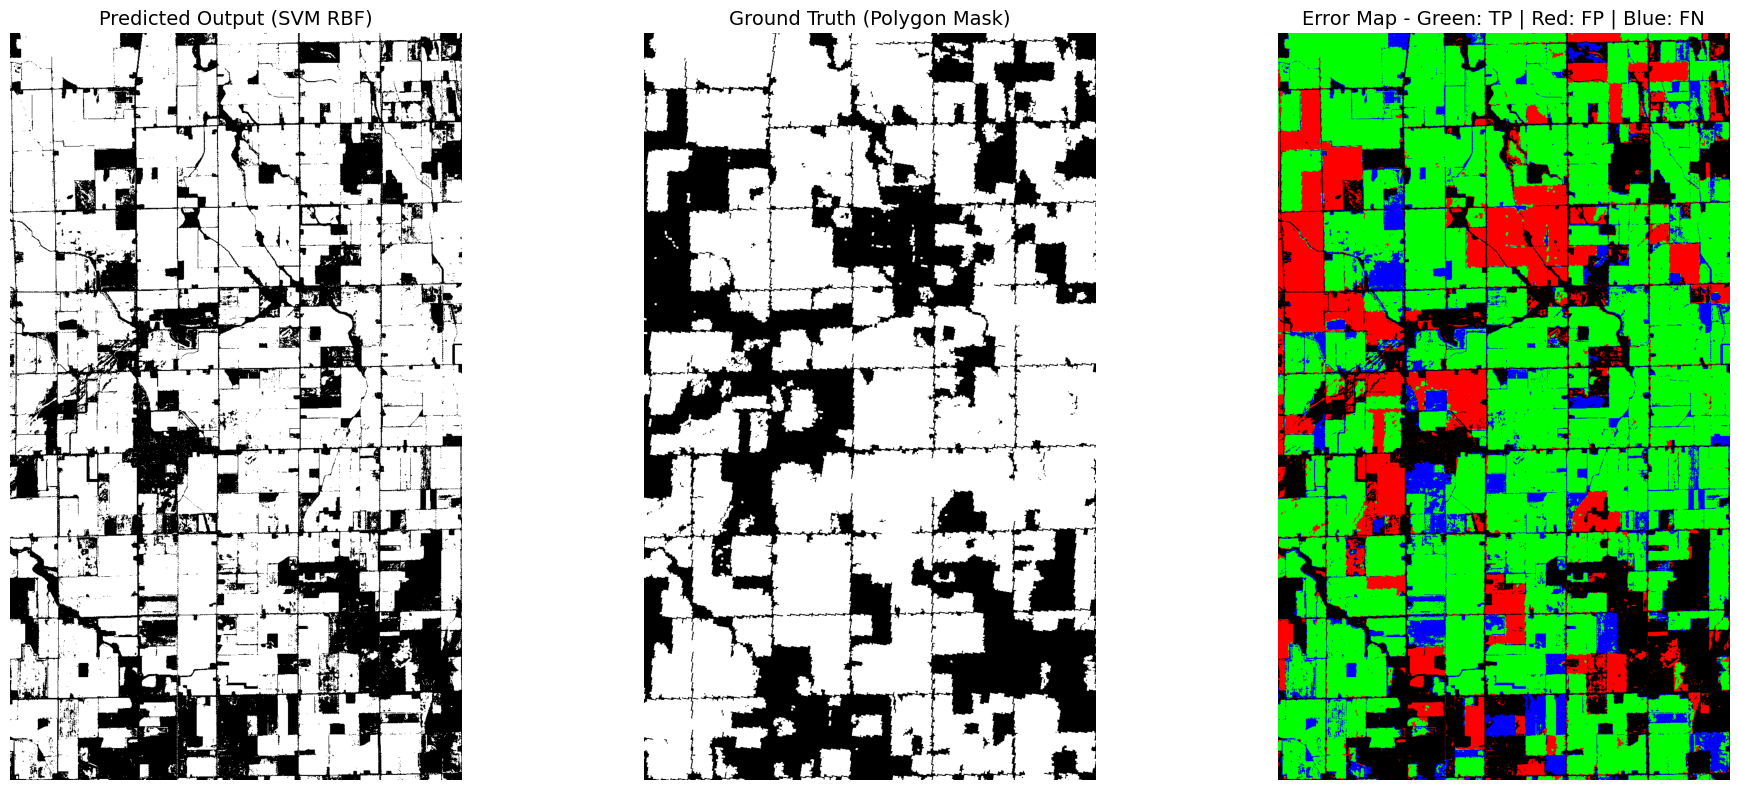

In [10]:
# === Step 8: Error Visualization Map ===
tp_mask = np.logical_and(polygon_mask == 1, pred_map == 1)
fp_mask = np.logical_and(polygon_mask == 0, pred_map == 1)
fn_mask = np.logical_and(polygon_mask == 1, pred_map == 0)

overlay_rgb = np.zeros((rows, cols, 3), dtype=np.uint8)
overlay_rgb[tp_mask] = [0, 255, 0]   # Green
overlay_rgb[fp_mask] = [255, 0, 0]   # Red
overlay_rgb[fn_mask] = [0, 0, 255]   # Blue

# === Plot Visualization ===
fig, axs = plt.subplots(1, 3, figsize=(20, 8))

# Panel 1: Predicted Mask
axs[0].imshow(pred_map, cmap='gray')
axs[0].set_title("Predicted Output (SVM RBF)", fontsize=14)
axs[0].axis('off')

# Panel 2: Ground Truth
axs[1].imshow(polygon_mask, cmap='gray')
axs[1].set_title("Ground Truth (Polygon Mask)", fontsize=14)
axs[1].axis('off')

# Panel 3: Error Map
axs[2].imshow(overlay_rgb)
axs[2].set_title("Error Map - Green: TP | Red: FP | Blue: FN", fontsize=14)
axs[2].axis('off')

plt.tight_layout()
plt.show()

In [12]:
# === Step 9: Detailed Metrics Summary ===

metrics = {
    "Confusion Matrix": {
        "True Negative (Background)": int(TN),
        "False Positive": int(FP),
        "False Negative": int(FN),
        "True Positive (Field)": int(TP),
    },
    "Classification Report": {
        "Precision (Field)": f"{class_report['Field']['precision']:.2f}",
        "Recall (Field)": f"{class_report['Field']['recall']:.2f}",
        "F1-Score (Field)": f"{class_report['Field']['f1-score']:.2f}",
        "Overall Accuracy": f"{class_report['accuracy']:.2f}"
    },
    "Pixel-Level Metrics": {
        "Pixel Accuracy (Recall)": f"{pixel_accuracy:.2%}",
        "IoU (Jaccard Index)": f"{iou:.2%}"
    },
    "Acreage Comparison": {
        "Predicted Acreage": round(pred_area_acres, 2),
        "Shapefile Acreage": round(true_area_acres, 2),
        "Acreage Error": round(error_acres, 2),
        "Error Percentage": f"{error_percent:.2f}%"
    }
}

# Optional: Pretty print the metrics for review
import pprint
print("\n===== SVM RBF Evaluation Summary (Detailed) =====")
pprint.pprint(metrics)



===== SVM RBF Evaluation Summary (Detailed) =====
{'Acreage Comparison': {'Acreage Error': 1748.24,
                        'Error Percentage': '8.20%',
                        'Predicted Acreage': 23069.66,
                        'Shapefile Acreage': 21321.42},
 'Classification Report': {'F1-Score (Field)': '0.82',
                           'Overall Accuracy': '0.75',
                           'Precision (Field)': '0.79',
                           'Recall (Field)': '0.85'},
 'Confusion Matrix': {'False Negative': 126251,
                      'False Positive': 197000,
                      'True Negative (Background)': 253486,
                      'True Positive (Field)': 736597},
 'Pixel-Level Metrics': {'IoU (Jaccard Index)': '69.50%',
                         'Pixel Accuracy (Recall)': '85.37%'}}
